In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

## Load Dataset

In [3]:
# Load Indoor sensors
def read_sensor_data(file_prefix, num_sensors=15):
    sensor_dataframes = []
    for i in range(1, num_sensors + 1):
        filename = f'00_data/calibrated_data/indoor_cal/{file_prefix}{i:02d}.csv'
        sensor_df = pd.read_csv(filename)
        sensor_dataframes.append(sensor_df)
    return sensor_dataframes

indoor_sensor_dataframes = read_sensor_data('Indoor')

In [ ]:
# Load outdoor sensors
def read_outdoor_sensor_data():
    outdoor_files = ['outdoor01.csv', 'outdoor02.csv', 'outdoor03.csv']
    outdoor_dataframes = []
    for idx, filename in enumerate(outdoor_files, start=1):
        df = pd.read_csv(f'00_data/calibrated_data/outdoor_cal/{filename}')
        df['Sensor'] = f'Outdoor {idx}'
        if idx == 1:
            df['Category'] = 'Rural'
        elif idx == 2:
            df['Category'] = 'Semi-Urban'
        else:
            df['Category'] = 'Urban'
        df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')
        df = df[(df['PM2.5'] >= 0) & (df['PM2.5'] <= 1000)]
        outdoor_dataframes.append(df[['Sensor', 'PM2.5','Temperature','Relative Humidity','Category','Timestamp_Local']])
    return outdoor_dataframes

outdoor_sensor_dataframes = read_outdoor_sensor_data()

## Calculate Unique Days

In [ ]:
def calculate_unique_days(sensor_dataframes):
    days_count = {}
    for i, df in enumerate(sensor_dataframes, start=1):
        df['Timestamp_Local'] = pd.to_datetime(df['Timestamp_Local'])

        # Extract the date and count unique dates
        unique_days = df['Timestamp_Local'].dt.date.nunique()
        days_count[f"Sensor {i}"] = unique_days
    return days_count

# Calculate number of unique days for each sensor
days_count = calculate_unique_days(indoor_sensor_dataframes)

In [24]:
def calculate_outdoor_unique_days(sensor_dataframes):
    days_count = {}
    for i, df in enumerate(sensor_dataframes, start=1):
        df['Timestamp_Local'] = pd.to_datetime(df['Timestamp_Local'])

        # Extract the date and count unique dates
        unique_days = df['Timestamp_Local'].dt.date.nunique()
        days_count[f"Outdoor {i}"] = unique_days
    return days_count

outdoor_days_count = calculate_outdoor_unique_days(outdoor_sensor_dataframes)

# Merge indoor and outdoor
all_days_count = {**days_count, **outdoor_days_count}

In [26]:
# Display the results
for sensor, count in all_days_count.items():
    print(f"{sensor} has {count} unique days.")

Sensor 1 has 55 unique days.
Sensor 2 has 142 unique days.
Sensor 3 has 125 unique days.
Sensor 4 has 100 unique days.
Sensor 5 has 120 unique days.
Sensor 6 has 109 unique days.
Sensor 7 has 129 unique days.
Sensor 8 has 118 unique days.
Sensor 9 has 122 unique days.
Sensor 10 has 83 unique days.
Sensor 11 has 96 unique days.
Sensor 12 has 128 unique days.
Sensor 13 has 86 unique days.
Sensor 14 has 82 unique days.
Sensor 15 has 113 unique days.
Outdoor 1 has 115 unique days.
Outdoor 2 has 110 unique days.
Outdoor 3 has 83 unique days.


## Data Summary

In [31]:
def summarize_outdoor_sensors_with_compiled(outdoor_sensor_dataframes):
    summary = {}

    compiled_df = pd.DataFrame()

    for df in outdoor_sensor_dataframes:
        df['Timestamp_Local'] = pd.to_datetime(df['Timestamp_Local'])
        df['Date'] = df['Timestamp_Local'].dt.date

        daily_means = df.groupby('Date')['PM2.5'].mean()
        category = df['Category'].iloc[0]

        summary[category] = {
            'Total days': daily_means.count(),
            'Mean of Daily Means': int(round(daily_means.mean())),
            'SD': int(round(daily_means.std())),
            '5th Percentile': int(round(daily_means.quantile(0.05))),
            '25th Percentile': int(round(daily_means.quantile(0.25))),
            '75th Percentile': int(round(daily_means.quantile(0.75))),
            '95th Percentile': int(round(daily_means.quantile(0.95))),
            'Median of Daily Medians': int(round(daily_means.median()))
        }

        # Append to compiled dataframe
        compiled_df = pd.concat([compiled_df, df], ignore_index=True)

    # Compile all data into one summary row
    compiled_df['Date'] = compiled_df['Timestamp_Local'].dt.date
    compiled_daily_means = compiled_df.groupby('Date')['PM2.5'].mean()

    summary['Compiled'] = {
        'Total days': compiled_daily_means.count(),
        'Mean of Daily Means': int(round(compiled_daily_means.mean())),
        'SD': int(round(compiled_daily_means.std())),
        '5th Percentile': int(round(compiled_daily_means.quantile(0.05))),
        '25th Percentile': int(round(compiled_daily_means.quantile(0.25))),
        '75th Percentile': int(round(compiled_daily_means.quantile(0.75))),
        '95th Percentile': int(round(compiled_daily_means.quantile(0.95))),
        'Median of Daily Medians': int(round(compiled_daily_means.median()))
    }

    return pd.DataFrame(summary).T

# Generate the outdoor summary table with compiled row
outdoor_summary_with_compiled = summarize_outdoor_sensors_with_compiled(outdoor_sensor_dataframes)

# Print result
outdoor_summary_with_compiled


,Total days,Mean of Daily Means,SD,5th Percentile,25th Percentile,75th Percentile,95th Percentile,Median of Daily Medians
Rural,115,30,5,23,27,33,38,29
Semi-Urban,110,31,8,23,26,34,45,30
Urban,83,31,8,22,25,35,47,30
Compiled,129,30,5,22,26,33,40,29


In [35]:
def summarize_nighttime_pm25_rounded(outdoor_sensor_dataframes):
    summary = {}
    compiled_df = pd.DataFrame()

    for df in outdoor_sensor_dataframes:
        df['Timestamp_Local'] = pd.to_datetime(df['Timestamp_Local'])
        df['Hour'] = df['Timestamp_Local'].dt.hour

        # Filter for 10 PM to 6 AM
        nighttime_df = df[(df['Hour'] >= 22) | (df['Hour'] < 6)].copy()
        nighttime_df['Date'] = nighttime_df['Timestamp_Local'].dt.date

        daily_means = nighttime_df.groupby('Date')['PM2.5'].mean()
        category = df['Category'].iloc[0]

        def safe_round(val):
            return int(round(val)) if pd.notna(val) else 'N/A'

        summary[category] = {
            'Mean of Daily Means': safe_round(daily_means.mean()),
            '5%th Percentile': safe_round(daily_means.quantile(0.05)),
            '95%th Percentile': safe_round(daily_means.quantile(0.95)),
            'Median of Daily Medians': safe_round(daily_means.median())
        }

        compiled_df = pd.concat([compiled_df, nighttime_df], ignore_index=True)

    # Compiled summary for all categories
    compiled_df['Date'] = compiled_df['Timestamp_Local'].dt.date
    compiled_daily_means = compiled_df.groupby('Date')['PM2.5'].mean()

    summary['Compiled'] = {
        'Mean of Daily Means': safe_round(compiled_daily_means.mean()),
        '5%th Percentile': safe_round(compiled_daily_means.quantile(0.05)),
        '95%th Percentile': safe_round(compiled_daily_means.quantile(0.95)),
        'Median of Daily Medians': safe_round(compiled_daily_means.median())
    }

    return pd.DataFrame(summary).T

# Run it
nighttime_summary_outdoor = summarize_nighttime_pm25_rounded(outdoor_sensor_dataframes)

# Display
nighttime_summary_outdoor


,Mean of Daily Means,5%th Percentile,95%th Percentile,Median of Daily Medians
Rural,28,21,40,27
Semi-Urban,27,20,37,26
Urban,29,22,42,27
Compiled,27,20,38,26


In [37]:
def summarize_weekend_pm25_rounded(outdoor_sensor_dataframes):
    summary = {}
    compiled_df = pd.DataFrame()

    for df in outdoor_sensor_dataframes:
        df['Timestamp_Local'] = pd.to_datetime(df['Timestamp_Local'])
        df['DayOfWeek'] = df['Timestamp_Local'].dt.weekday  # Monday=0, Sunday=6

        # Filter for weekends (Saturday: 5, Sunday: 6)
        weekend_df = df[df['DayOfWeek'].isin([0,1,2,3,4])].copy()
        weekend_df['Date'] = weekend_df['Timestamp_Local'].dt.date

        daily_means = weekend_df.groupby('Date')['PM2.5'].mean()
        category = df['Category'].iloc[0]

        def safe_round(val):
            return int(round(val)) if pd.notna(val) else 'N/A'

        summary[category] = {
            'Mean of Daily Means': safe_round(daily_means.mean()),
            '5%th Percentile': safe_round(daily_means.quantile(0.05)),
            '95%th Percentile': safe_round(daily_means.quantile(0.95)),
            'Median of Daily Medians': safe_round(daily_means.median())
        }

        compiled_df = pd.concat([compiled_df, weekend_df], ignore_index=True)

    # Compiled summary for all categories
    compiled_df['Date'] = compiled_df['Timestamp_Local'].dt.date
    compiled_daily_means = compiled_df.groupby('Date')['PM2.5'].mean()

    summary['Compiled'] = {
        'Mean of Daily Means': safe_round(compiled_daily_means.mean()),
        '5%th Percentile': safe_round(compiled_daily_means.quantile(0.05)),
        '95%th Percentile': safe_round(compiled_daily_means.quantile(0.95)),
        'Median of Daily Medians': safe_round(compiled_daily_means.median())
    }

    return pd.DataFrame(summary).T

# Run it
weekend_summary_outdoor = summarize_weekend_pm25_rounded(outdoor_sensor_dataframes)

# Display
weekend_summary_outdoor

,Mean of Daily Means,5%th Percentile,95%th Percentile,Median of Daily Medians
Rural,29,22,37,29
Semi-Urban,31,23,45,30
Urban,31,22,46,30
Compiled,30,22,40,29


## Violin Plots

In [7]:
# Urban, Rural, and Semi-Urban sensors
all_indoor_data = []
urban_sensors = [7, 8, 9, 11, 14]
rural_sensors = [2, 4, 5, 6, 10]
semi_urban_sensors = [1, 3, 12, 13, 15]

## Seperate

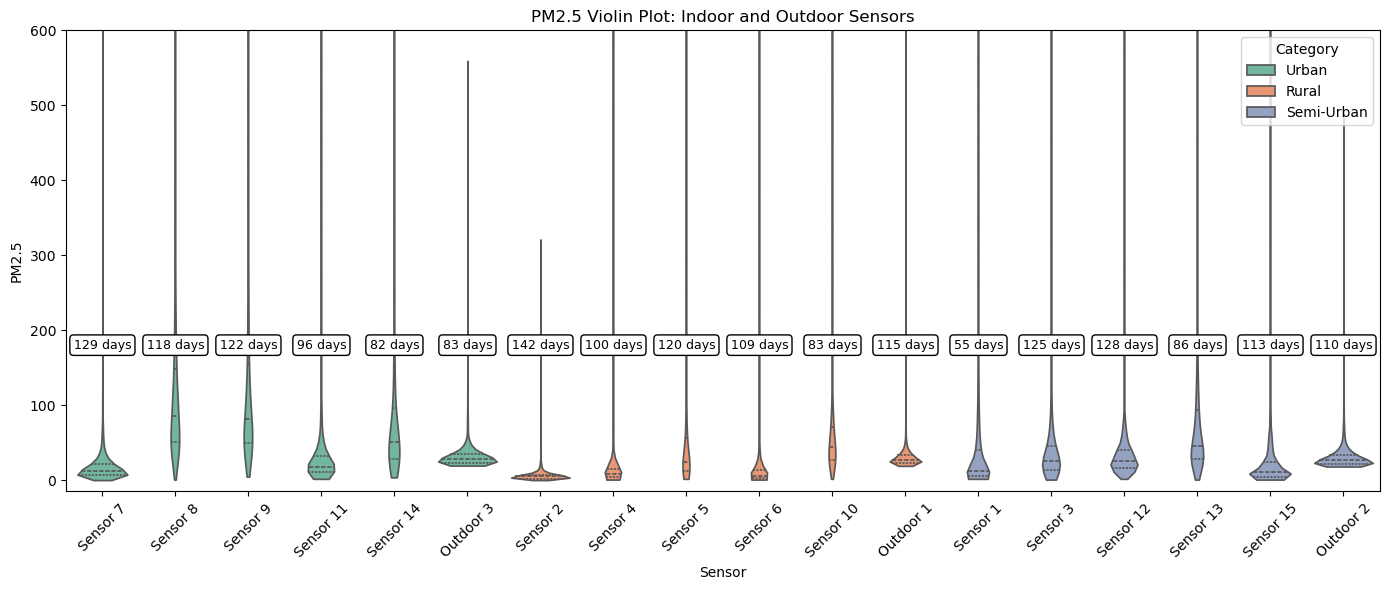

In [27]:
for i, df in enumerate(indoor_sensor_dataframes, start=1):
    if i in urban_sensors:
        category = 'Urban'
    elif i in rural_sensors:
        category = 'Rural'
    else:
        category = 'Semi-Urban'
    df['Category'] = category
    df['Sensor'] = f"Sensor {i}"
    df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')
    df_filtered = df[(df['PM2.5'] >= 0) & (df['PM2.5'] <= 1000)]
    all_indoor_data.append(df_filtered[['Sensor', 'PM2.5', 'Category']])

# Combine indoor + outdoor data
all_data_df = pd.concat(all_indoor_data + outdoor_sensor_dataframes, ignore_index=True)

# Custom sensor order: Indoor first, Outdoor last
sensor_order = [
    'Sensor 7', 'Sensor 8', 'Sensor 9', 'Sensor 11', 'Sensor 14', 'Outdoor 3',  # Urban
    'Sensor 2', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 10', 'Outdoor 1',   # Rural
    'Sensor 1', 'Sensor 3', 'Sensor 12', 'Sensor 13', 'Sensor 15', 'Outdoor 2'  # Semi-Urban
]

# Plot
plt.figure(figsize=(14, 6))
ax = sns.violinplot(
    data=all_data_df,
    x='Sensor',
    y='PM2.5',
    hue='Category',
    inner='quart',
    palette='Set2',
    hue_order=['Urban', 'Rural', 'Semi-Urban'],
    order=sensor_order,
    cut=0
)

for i, sensor in enumerate(sensor_order):
    unique_days = all_days_count.get(sensor, 'N/A')
    ax.text(
        i,
        180,  
        f'{unique_days} days',
        ha='center',
        va='center',
        fontsize=9,
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.ylim(-15, 600)
plt.xticks(rotation=45)
plt.title('PM2.5 Violin Plot: Indoor and Outdoor Sensors')
plt.xlabel('Sensor')
plt.ylabel('PM2.5')

plt.tight_layout()
plt.show()